<a href="https://colab.research.google.com/github/ammarisme/covid-19/blob/master/CV19_result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from functools import reduce
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on '+ ("GPU" if torch.cuda.is_available() else "CPU"))

running on CPU


In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/covid'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def loss_file_search(mypath):
  losses_files = [f for f in listdir(mypath) if ("losses" in f)]
  ax_paths = []
  for loss_file in losses_files:
    losses = np.load(join(mypath, loss_file), allow_pickle=True)
    training_loss = np.array(losses.tolist()['losses']).T[0]
    ax = plt.plot(training_loss)
    filepath = mypath
    ax_paths.append((ax, filepath))
  
  directories = [f for f in listdir(mypath) if os.path.isdir(join(mypath, f))]
  for directory in directories:
    ax_paths.append(loss_file_search(mypath+'/'+directory))
  
  return ax_paths
  

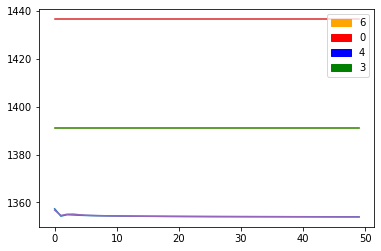

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim

import matplotlib.patches as mpatches



plt.show()
root = PATH+'/models__rnn/run11'
#ylim(top=5.08, bottom=5.07)#, ylim_bottom=5.0
ax_paths = loss_file_search(root)
axes = [ax_path[0][0] for ax_path in ax_paths]
paths = [ax_path[0][1][-1] for ax_path in ax_paths]
colors = {
    0 :"red",
    3 : "green",
    4 : "blue",
    6: "orange"
}
plt.legend(handles=[
                    mpatches.Patch(color=colors[int(path)], label=str(path)) for path in paths])
plt.show()

In [0]:
def get_all_directories(mypath):  
  directories= [f for f in listdir('/'+mypath) if os.path.isdir(join(mypath, f))]
  for directory in directories:
    get_all_directories(directory)
    #loss_file_search(mypath+'/'+directory)

get_all_directories(PATH)

FileNotFoundError: ignored

In [0]:
def loss_analysis(losses):
 print('loss analysis') 

['CV19 Cleaning.ipynb',
 'CV19_Synthesis.ipynb',
 '_Common.ipynb',
 'common (1).py',
 'common.py',
 'CV19Net.ipynb',
 'rnn_model_configurations_1001_443838.csv',
 'rnn_model_configurations_1001_165567.csv',
 'rnn_model_configurations_1001_353166.csv',
 'rnn_model_configurations_1001_57460.csv',
 'rnn_model_configurations_1001_981028.csv',
 'CV19 Dataset Explore.ipynb',
 'CV19_Dataset.ipynb',
 'RNN-CV19Net.ipynb',
 'CV19-result-analysis.ipynb']